In [1]:
import numpy as np
import networkx as nx
from dwdynamics import helpers ,instance
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy.stats import linregress
import dwave_networkx as dnx
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
import dimod
import math
import minorminer

In [2]:

helpers.set_pub_style(scale=1.0, fontsize=16)

In [3]:
helpers.get_dwave_sample_set(system=1,timepoints=2)

SampleSet(rec.array([([1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1], 0. , 616, 0.),
           ([1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1], 0.5,  14, 0.),
           ([1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], 0.5,  10, 0.),
           ([1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0], 0.5,  25, 0.),
           ([1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1], 0.5,   7, 0.),
           ([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], 0.5,  11, 0.),
           ([1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1], 0.5,  11, 0.),
           ([1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1], 0.5,  17, 0.),
           ([1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1], 0.5,  36, 0.),
           ([1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0], 0.5,  18, 0.),
           ([1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1], 0.5,  25, 0.),
           ([1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0], 0.5,  15, 0.),
           ([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1], 0.5,

0.24999999999999745
0.12499999999999956
0.24999999999999623
0.24999999999999634
0.24999999999999678
0.24999999999999756
0.2499999999999981
0.24999999999999678
0.249999999999998
0.24999999999999745
0.374999999999996
0.24999999999999722
0.12499999999999856
0.249999999999999
0.2499999999999981
0.24999999999999922
(2, 2)


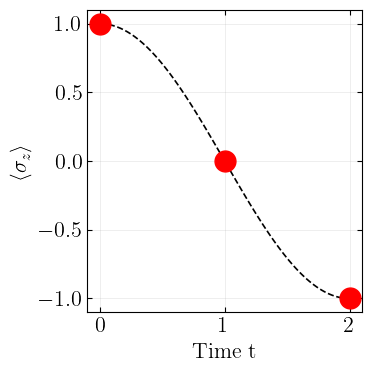

In [4]:
import qutip as qp

system = 3

tp_pairs = [(3,3)]
# We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...

# Loop over all rows in velox_results and plot all dynamics on the same panel,
# coloring each curve according to its best_energy.
colors = ["r", "g", "b", "c", "m", "y", "k"]
markers = ["o", "s", "^", "D", "v", "<", ">"]

SY = np.array([[0, -1.0j], [1.0j, 0.0]])
PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.


# Create a single axis for the plot
fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharey=False)

system_latex_dict = {
    1: 'H = $\\frac{\\pi}{2}\\sigma_y$',
    3: 'one qubit pt symmetric system (seed=1)',
    4: 'maximally entangled 2 qubit system'
}



for i, (timepoints,precision) in enumerate(tp_pairs):

    s = helpers.get_dwave_sample_set(system, timepoints)
    inst = instance.Instance(system)
    inst.create_instance(precision, timepoints)
    H = inst.H
    PSI0 = inst.psi0
    dim = int(math.log2(H.shape[0]))    #dim=2

    print(H.shape)
    


    #psi_0 = qp.tensor(qp.basis(2, 0), qp.basis(2, 1))
    times = np.linspace(0, timepoints-1, 100)
    baseline = qp.mesolve(qp.Qobj(H), qp.Qobj(PSI0), times, e_ops=[qp.sigmaz()]).expect
    
    ax.plot(times, baseline[0], "k--",label="|00>")


    problem = inst.problem

    sample = s.first.sample
    sample_energy = s.first.energy
    vec =problem.interpret_sample(sample)

    expect_00 = [(state.conj()@ qp.sigmaz().full() @ state).real for state in vec]

    ax.plot(problem.times, expect_00,label=f"|00> Energy: {round(sample_energy,4)}", marker='o',markersize=15,linestyle='None',alpha=1.0,color='red')
#    ax.scatter(problem.times, expect_11, color='black', marker=markers[j % len(markers)],label=f"|11> Energy: {sample_energy,4)}", alpha=1.0, s=100)

        #ax.plot(problem.times, expect, color=colors[j % len(colors)], alpha=0.5, linewidth=0.1)
    ax.set_xlabel("Time t")
    ax.set_ylabel(r"$\langle \sigma_z \rangle$")
#fig.suptitle(f"Advantage {topology} " +rf"evolution of {system} ",fontsize=16)
ax.set_xticks(np.arange(0, timepoints, 1))  # Show all integer timepoints as xticks
plt.tight_layout()
plt.savefig(f'../plots/dynamic_{system}.pdf',bbox_inches='tight')
plt.show()



# Performance comparison Velox vs D-Wave

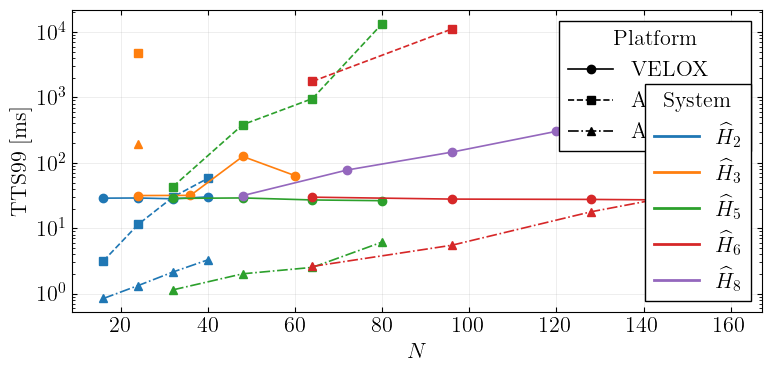

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))
colors = plt.cm.tab10.colors  # do 10 systemów
systems = [i for i in range(1,10)]
systems = [2,3,5,6,8]
ALL_dfs = []

native_systems = [1,2,4,5,6,7]

for idx, system in enumerate(systems):
    velox_tts = helpers.get_velox_tts(system)
    df2_filtered = helpers.get_dwave_success_rates(system=system,ta=200,topology='6.4',file_limit=20)
    df3_filtered = helpers.get_dwave_success_rates(system=system,ta=200,topology='1.4',file_limit=20)

    df2_filtered['source'] = 'Advantage'
    df3_filtered['source'] = 'Advantage2'

    combined = pd.concat([df2_filtered,df3_filtered]).reset_index()
    combined =combined[combined.timepoints.isin([2,3,4,5])]


    combined['system'] = system
    combined['x_label'] = combined['precision'].astype(str) + '\n' + combined['timepoints'].astype(str)
    
    combined['tts99'] = combined.apply(lambda row: helpers.return_tts(row['success_prob'],row.runtime),axis=1)
    df = combined.copy()
    
    advantage1 = df[df['source'] == 'Advantage'].dropna(subset=['num_var', 'tts99'])
    advantage2 = df[df['source'] == 'Advantage2'].dropna(subset=['num_var', 'tts99'])
    combined = combined[['system','source','precision','num_var','timepoints','runtime','success_prob','tts99']]
    color = colors[idx % len(colors)]
    
    ax.plot(velox_tts['num_var'], velox_tts['tts99'],
            marker='o', linestyle='-', color=color, label=f'system {system}')
    
    ax.plot(advantage1['num_var'], advantage1['tts99'],
            marker='s', linestyle='--', color=color)
    
    ax.plot(advantage2['num_var'], advantage2['tts99'],
            marker='^', linestyle='dashdot', color=color)
    
    ALL_dfs.append(combined)
all_system_dfs = pd.concat(ALL_dfs,axis=0)
native_system_df = all_system_dfs[all_system_dfs.system.isin(native_systems)].groupby(['source','precision','num_var','timepoints']).mean().reset_index().drop(labels=['system'],axis=1)
sources = ['Advantage', 'Advantage2']



# 1st legend : solver
style_legend = [
    Line2D([0], [0], color='black', linestyle='-', marker='o', label='VELOX'),
    Line2D([0], [0], color='black', linestyle='--', marker='s', label='Advantage'),
    Line2D([0], [0], color='black', linestyle='dashdot', marker='^', label='Advantage2')
]

legend1 = ax.legend(handles=style_legend, title='Platform', loc='upper right')

# 2nd legend : systems
color_legend = [
    Line2D([0], [0], color=colors[idx % len(colors)], lw=2, label=fr'$\widehat H_{s}$') for idx, s in enumerate(systems)
]

legend2 = ax.legend(handles=color_legend, title='System', loc='lower right')
ax.add_artist(legend1) 

ax.set_xlabel(r'$N$')
ax.set_ylabel('TTS99 [ms]')
ax.set_yscale('log')
ax.grid(True)
plt.tight_layout()
#plt.savefig(f'../plots/tta_overview.pdf' ,bbox_inches='tight')
ylims = ax.get_ylim()
plt.show()

--------------
System 1
   precision  timepoints  num_var      tts99  system source
0          2           2       16  29.487958       1  VELOX
1          2           3       24  34.158950       1  VELOX
2          2           4       32  29.933575       1  VELOX
3          2           5       40  29.329903       1  VELOX
--------------
System 2
   precision  timepoints  num_var      tts99  system source
0          2           2       16  28.839828       2  VELOX
1          2           3       24  29.004718       2  VELOX
2          2           4       32  28.198136       2  VELOX
3          2           5       40  30.123493       2  VELOX
--------------
System 5
   precision  timepoints  num_var      tts99  system source
0          2           2       32  28.576991       5  VELOX
1          2           3       48  29.059432       5  VELOX
2          2           4       64  27.064886       5  VELOX
3          2           5       80  26.379676       5  VELOX
--------------
System 2
   p

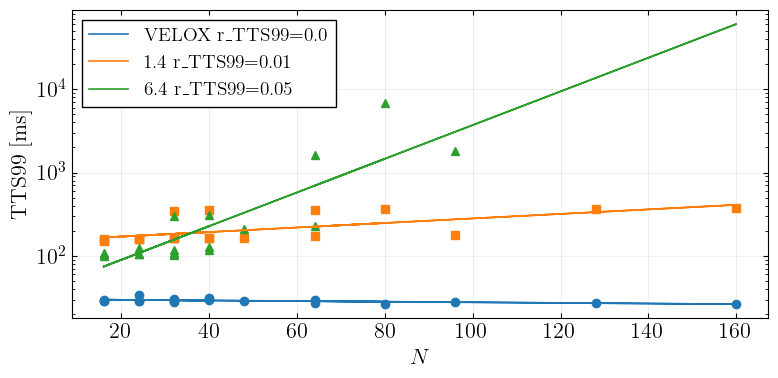

array([   74.54486442,   108.13999874,   156.87545236,   227.57451304,
          74.54486442,   108.13999874,   156.87545236,   227.57451304,
         156.87545236,   330.13551967,   694.7515351 ,  1462.065324  ,
         694.7515351 ,  3076.83380841, 13626.31934765, 60346.63895609,
          74.54486442,   108.13999874,   156.87545236,   227.57451304])

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))
colors = plt.cm.tab10.colors  # do 10 systemów
systems = [i for i in range(1,10)]
systems = [2,3,4,6,8]
ALL_dfs = []
helpers.set_pub_style(fontsize=14)
native_systems = [1,2,5,6,7]

for idx, system in enumerate(native_systems):
    velox_tts = helpers.get_velox_tts(system)
    dwave_14_tts = helpers.get_dwave_tts(system,topology='1.4',file_limit=20)
    dwave_64_tts = helpers.get_dwave_tts(system,topology='6.4',file_limit=20)

    color = colors[idx % len(colors)]

    print("--------------")
    print(f"System {system}")
    print(velox_tts)
    ax.plot(velox_tts['num_var'], velox_tts['tts99'],
            marker='o', linestyle='None', color=colors[0], label=f'velox' if system==0 else None)
    
    ax.plot(dwave_14_tts['num_var'], dwave_14_tts['tts99'],
            marker='s', linestyle='None', color=colors[1],label='14' if system==0 else None)
    
    ax.plot(dwave_64_tts['num_var'], dwave_64_tts['tts99'],
            marker='^', linestyle='None', color=colors[2],label='64' if system==0 else None)
    ALL_dfs.append(velox_tts)
    ALL_dfs.append(dwave_14_tts)
    ALL_dfs.append(dwave_64_tts)
sources = ['VELOX','1.4', '6.4']
linestyles = ['-','-','-']
all_system_dfs = pd.concat(ALL_dfs,axis=0)
native_system_df = all_system_dfs[all_system_dfs.system.isin(native_systems)]

for i,source in enumerate(sources):

    native_system_df_filtered = native_system_df[native_system_df.source == source]
    num_var = np.array(native_system_df_filtered['num_var'])       
    TTS99 = np.array(native_system_df_filtered['tts99'])           

    mask = np.isfinite(TTS99)
    num_var_clean = num_var[mask]
    TTS99_clean = TTS99[mask]
    log_TTS99 = np.log(TTS99_clean)

    slope, intercept, r_value, p_value, std_err = linregress(num_var_clean, log_TTS99)

    r_TTS99 = slope
    D =np.exp(intercept)
    t = D * np.exp(r_TTS99 * num_var)

    TTS99_fit = D * np.exp(r_TTS99 * num_var)
    ax.plot(num_var, TTS99_fit, linestyle=linestyles[i], color=colors[i], label=f'{source} r_TTS99={abs(np.round(r_TTS99,2))}')    

plt.legend()
ax.set_xlabel(r'$N$')
ax.set_ylabel('TTS99 [ms]')
plt.yscale('log')
ax.grid(True)
plt.tight_layout()
plt.savefig(f'../plots/tta_overview.pdf' ,bbox_inches='tight')
#ax.set_ylim(0,1e6)
ylims = ax.get_ylim()

plt.show()
TTS99_fit

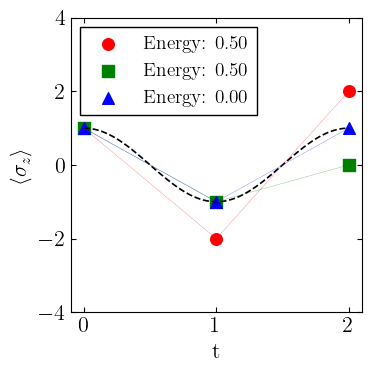

0.24999999999999745
0.12499999999999956
0.24999999999999623
0.24999999999999634
0.24999999999999678
0.24999999999999756
0.2499999999999981
0.24999999999999678
0.249999999999998
0.24999999999999745
0.374999999999996
0.24999999999999722
0.12499999999999856
0.249999999999999
0.2499999999999981
0.24999999999999922


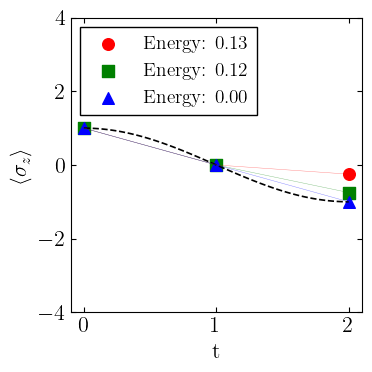

In [18]:
helpers.set_pub_style(fontsize=16,grid=False)

# Define sigma_z for manual computation of expected values

SZ = np.array([[1, 0], [0, -1]])
colors = ["r", "g", "b", "c", "m", "y", "k"]
markers = ["o", "s", "^", "D", "v", "<", ">"]
system = 3
tp = 3
prec = [2,3]
for j,system in enumerate([1,3]):
    fig, ax = plt.subplots(1,1,figsize=(4, 4))

    i = instance.Instance(system)

    i.create_instance(precision=prec[j],number_time_points=tp)
    qubo = i.problem.qubo()
    problem = i.problem
    times = np.linspace(0, len(problem.times)-1, 100)

    baseline = qp.mesolve(qp.Qobj(problem.hamiltonian), qp.Qobj(problem.initial_state), times, e_ops=[qp.sigmaz()]).expect[0]
    ax.plot(times, baseline, "k--")
    dw_result = helpers.get_dwave_sample_set(system,timepoints=3)

    for idx,sample in enumerate(list(dw_result.samples(3))[::-1]):
        dw_vec = problem.interpret_sample(sample)
        dw_expect = [(state.conj() @ SZ @ state).real for state in dw_vec]
        energy = list(dw_result.to_pandas_dataframe()[0:3][::-1]['energy'])[idx]

        #axis.scatter(inst_obj.problem.times, exact_expect, marker="^", lw=2, s=300, edgecolors="b", facecolors="none", label="Exact solver")
        #axis.scatter(problem.times, sa_expect, marker="o", lw=2, s=100, edgecolors="r", facecolors="none", label="SA sampler")
        ax.scatter(problem.times, dw_expect,color=colors[idx % len(colors)], marker=markers[idx % len(markers)],label=f"Energy: {abs(energy):.2f}",s=70)
        ax.plot(problem.times, dw_expect, color=colors[idx % len(colors)], alpha=0.5, linewidth=0.3)
        ax.set_xlabel("t")
        ax.legend(loc='upper left',fontsize=14)


        ax.set_ylabel(r"$\langle \sigma_z \rangle$")
    plt.ylim(-4,4)
    plt.tight_layout(w_pad=2)
    plt.savefig(f'../plots/dynamics_system_{system}_list.pdf' ,bbox_inches='tight')
    plt.show()

/tmp/ipykernel_29688/563123218.py:46: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  slope, intercept, r_value, p_value, std_err = linregress(num_var_clean, log_TTS99)


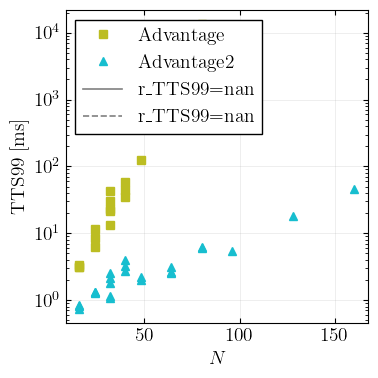

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))
colors = plt.cm.tab10.colors  # do 10 systemów
systems = [i for i in range(1,10)]
systems = [1,2,4,5,6,7]
ALL_dfs = []

for idx, system in enumerate(systems):
    df2_filtered = helpers.get_dwave_success_rates(system=system,ta=200,topology='6.4',file_limit=20)
    df3_filtered = helpers.get_dwave_success_rates(system=system,ta=200,topology='1.4',file_limit=20)

    # Dodajemy identyfikator źródła
    df2_filtered['source'] = 'Advantage'
    df3_filtered['source'] = 'Advantage2'

    # Łączymy oba DataFrame'y
    combined = pd.concat([df2_filtered,df3_filtered])
    # Reset indeksu do kolumn
    combined = combined.reset_index()
    combined =combined[combined.timepoints.isin([2,3,4,5])]
    # Tworzymy etykiety X
    combined['system'] = system
    combined['x_label'] = combined['precision'].astype(str) + '\n' + combined['timepoints'].astype(str)
    combined['tts99'] = combined.apply(lambda row: helpers.return_tts(row['success_prob'],row.runtime),axis=1)
    df = combined.copy()
    
    advantage1 = df[df['source'] == 'Advantage'].dropna(subset=['num_var', 'tts99'])
    advantage2 = df[df['source'] == 'Advantage2'].dropna(subset=['num_var', 'tts99'])

    
    ax.plot(advantage1['num_var'], advantage1['tts99'],'s', color=colors[8],label='Advantage' if system==1 else None)
    
    ax.plot(advantage2['num_var'], advantage2['tts99'],'^', color=colors[9],label='Advantage2' if system==1 else None)

linestyles = ['-','--']
sources=['Advantage','Advantage2']
for i,source in enumerate(sources):
    native_system_df_filtered = native_system_df[native_system_df.source == source]
    num_var = np.array(native_system_df_filtered['num_var'])        
    TTS99 = np.array(native_system_df_filtered['tts99'])           
    
    mask = np.isfinite(TTS99)
    num_var_clean = num_var[mask]
    TTS99_clean = TTS99[mask]
    log_TTS99 = np.log(TTS99_clean)

    slope, intercept, r_value, p_value, std_err = linregress(num_var_clean, log_TTS99)

    r_TTS99 = slope
    D =np.exp(intercept)
    t = D * np.exp(r_TTS99 * num_var)

    TTS99_fit = D * np.exp(r_TTS99 * num_var)
    plt.semilogy(num_var, TTS99_fit, linestyles[i], label=f'r_TTS99={np.round(r_TTS99,2)}',color='grey')

plt.legend(loc='upper left')

ax.set_xlabel(r'$N$')
ax.set_ylabel('TTS99 [ms]')
ax.set_yscale('log')
#ax.set_ylim(ylims)
ax.grid(True)
plt.tight_layout()
plt.savefig(f'../plots/tta_exponent_factor.pdf' ,bbox_inches='tight')
plt.show()



## Success rates

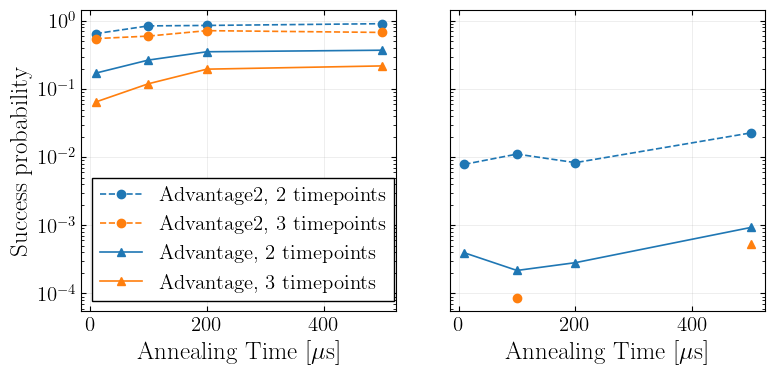

In [8]:
import pandas as pd
helpers.set_pub_style(scale=1.0, fontsize=15)
annealing_times = [10,100,200,500]
timepoints_of_interest = [2, 3]
topologies = ['1.4', '6.4']
solver_names = {
    '1.4':'Advantage2',
    '6.4':'Advantage',
}
systems = [1,3]

# przygotowanie figure z dwoma subplotami
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
colors = {2: 'tab:blue', 3: 'tab:orange'}
linestyles = {'1.4': 'dashed', '6.4': 'solid'}
markers = {'1.4': 'o', '6.4': '^'}
titles = {2: rf'$\left| \Psi_{system} \right\rangle$', 9: '^'}


for ax, system in zip(axes, systems):
    data = {tp: {t: [] for t in timepoints_of_interest} for tp in topologies}

    for topology in topologies:
        for ta in annealing_times:
            df = helpers.get_dwave_success_rates(system, topology=topology, ta=ta, grouped=True,file_limit=20)
            df = df[df['timepoints'].isin(timepoints_of_interest)]
            for tp in timepoints_of_interest:
                val = df[df['timepoints'] == tp]['success_prob'].values
                data[topology][tp].append(val[0] if len(val) > 0 else None)

    for topology in topologies:
        for tp in timepoints_of_interest:
            tas = [ta for i,ta in enumerate(annealing_times) if data[topology][tp][i] >0 ]
            data[topology][tp] = [p for p in data[topology][tp] if p >0]
            ax.plot(
                tas,
                data[topology][tp],
                label=f'{solver_names[topology]}, {tp} timepoints',
                color=colors[tp],
                linestyle=linestyles[topology],
                marker=markers[topology]
            )

    #ax.set_title(rf'$\widehat K_{system}$')
    ax.set_xlabel(r'Annealing Time [$\mu$s]',fontsize=18)
    ax.set_yscale('log')
    ax.grid(True)

axes[0].set_ylabel('Success probability',fontsize=18)
axes[0].legend(loc='lower left')
plt.tight_layout()
plt.savefig(f'../plots/system_2_9_ta.pdf',bbox_inches='tight')
plt.show()


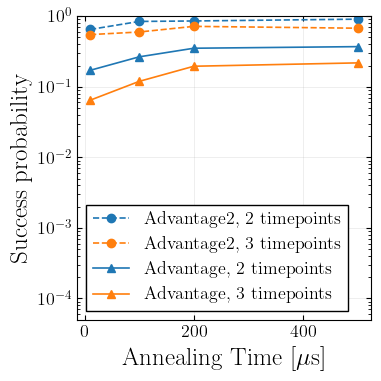

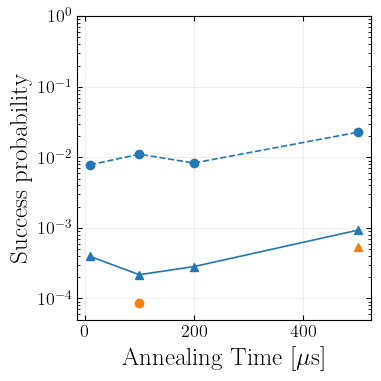

In [9]:
import pandas as pd
helpers.set_pub_style(scale=1.0, fontsize=13)
annealing_times = [10,100,200,500]
timepoints_of_interest = [2, 3]
topologies = ['1.4', '6.4']
solver_names = {
    '1.4':'Advantage2',
    '6.4':'Advantage',
}
systems = [1,3]

# przygotowanie figure z dwoma subplotami
colors = {2: 'tab:blue', 3: 'tab:orange'}
linestyles = {'1.4': 'dashed', '6.4': 'solid'}
markers = {'1.4': 'o', '6.4': '^'}
titles = {2: rf'$\left| \Psi_{system} \right\rangle$', 9: '^'}


for system in  systems:
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    data = {tp: {t: [] for t in timepoints_of_interest} for tp in topologies}

    for topology in topologies:
        for ta in annealing_times:
            df = helpers.get_dwave_success_rates(system, topology=topology, ta=ta, grouped=True,file_limit=20)
            df = df[df['timepoints'].isin(timepoints_of_interest)]
            for tp in timepoints_of_interest:
                val = df[df['timepoints'] == tp]['success_prob'].values
                data[topology][tp].append(val[0] if len(val) > 0 else None)

    for topology in topologies:
        for tp in timepoints_of_interest:
            tas = [ta for i,ta in enumerate(annealing_times) if data[topology][tp][i] >0 ]
            data[topology][tp] = [p for p in data[topology][tp] if p >0]
            ax.plot(
                tas,
                data[topology][tp],
                label=f'{solver_names[topology]}, {tp} timepoints',
                color=colors[tp],
                linestyle=linestyles[topology],
                marker=markers[topology]
            )

    #ax.set_title(rf'$\widehat K_{system}$')
    ax.set_xlabel(r'Annealing Time [$\mu$s]',fontsize=18)
    ax.set_yscale('log')
    ax.grid(True)

    ax.set_ylabel('Success probability',fontsize=18)
    if system ==1:
        ax.legend(loc='lower left')
    ax.set_ylim(5e-5,1)

    plt.tight_layout()

    plt.savefig(f'../plots/system_{system}_ta.pdf',bbox_inches='tight')
    plt.show()


In [10]:
annealing_times = [10,100,200,500]
timepoints_of_interest = [2]
topologies = ['1.4', '6.4']
solver_names = {
    '1.4':'Advantage2',
    '6.4':'Advantage',
}
native_systems = [1,2,4,5,6,7]
not_native_systems = [3,8]

ratio_dfs = []


for systems in [native_systems, not_native_systems]:
    dfs =[]
    for system in systems:
        for topology in topologies:
            for ta in annealing_times:
                df = helpers.get_dwave_success_rates(system, topology=topology, ta=ta, grouped=True)
                df = df[df['timepoints'].isin(timepoints_of_interest)]
                df['system'] = system
                df['ta'] = ta
                dfs.append(df)

    combined_df = pd.concat(dfs)
    combined_df = combined_df[['topology','success_prob','ta']].groupby(by=['topology','ta']).mean()
    df_reset = combined_df.reset_index()

    df_14 = df_reset[df_reset['topology'] == '1.4'].set_index('ta')[['success_prob']]
    df_64 = df_reset[df_reset['topology'] == '6.4'].set_index('ta')[['success_prob']]
    ratio_dfs.append(df_14 / df_64)

In [11]:
ratio_df = ratio_dfs[0].copy()
ratio_df['p_ratio_non_native'] = ratio_dfs[1]['success_prob'].copy() 
ratio_df=ratio_df.rename({'success_prob':'p_ratio_native'},axis=1)
print(ratio_df.to_latex())

\begin{tabular}{lrr}
\toprule
 & p_ratio_native & p_ratio_non_native \\
ta &  &  \\
\midrule
10 & 5.240761 & 19.882828 \\
100 & 4.628113 & 51.031250 \\
200 & 4.045027 & 22.351648 \\
500 & 3.733719 & 24.429150 \\
\bottomrule
\end{tabular}



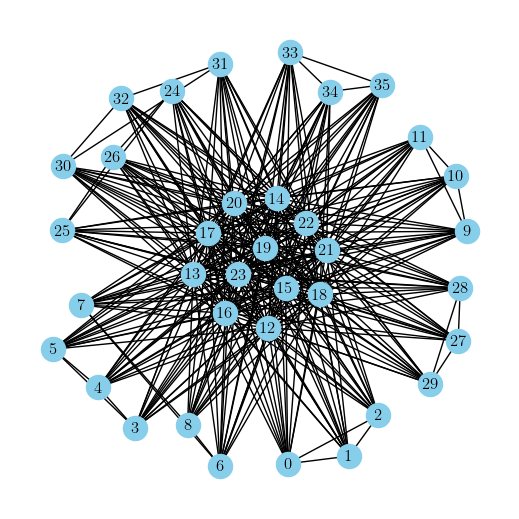

In [12]:
system = 3
inst = instance.Instance(system)
inst.create_instance(precision=3, number_time_points=3)
G = dimod.to_networkx_graph(inst.qubo)

# Układ siłowy z większym parametrem k
pos = nx.spring_layout(G, k=5, seed=42)  # większe k => większe odległości

fig = plt.figure(figsize=(5, 5))
fig.tight_layout()
nx.draw(G, with_labels=True, node_color='skyblue', edge_color='black')
plt.savefig(f'../plots/system{system}_before_emb_spread.pdf', bbox_inches='tight')

{1: [254, 253], 0: [83, 82], 2: [256, 257], 12: [207, 71, 70, 208], 13: [98, 198, 200, 199, 97], 14: [77, 186, 187, 76], 15: [223, 73, 222, 74], 16: [225, 79, 226, 80], 17: [110, 195, 196, 109, 197], 18: [201, 104, 103, 202, 203], 19: [93, 95, 94, 213, 214], 20: [210, 211, 101, 100], 21: [112, 228, 229, 230, 113], 22: [204, 92, 91, 205, 90], 23: [68, 67, 219, 220], 3: [194, 46, 193], 4: [175, 85, 84], 5: [88, 190, 87], 6: [60, 61], 7: [217, 218], 8: [63, 64], 9: [33, 34], 10: [30, 31], 11: [58, 174, 57], 24: [44, 43], 25: [189, 52, 51], 26: [238, 239], 27: [40, 41], 28: [37, 38], 29: [240, 48, 49], 30: [107, 245, 244], 31: [235, 236], 32: [243, 54, 55], 33: [137, 241, 242], 34: [247, 248], 35: [250, 251]}


/tmp/ipykernel_29688/3515835779.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


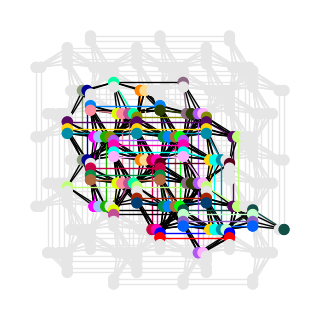

In [13]:
def visualize_embedding(bqm, target='pegasus', shape=None, embed=None):
    """
    Osadzenie i wizualizacja BQM na grafie Pegasus lub Zephyr.
    
    target : 'pegasus' lub 'zephyr'
    shape   :
      - Pegasus: int (np. 16)
      - Zephyr : tuple (m, n, t) (np. (4, 4, 4))
    """
    if target == 'pegasus':
        hw = dnx.pegasus_graph(shape)
    elif target == 'zephyr':
        hw = dnx.zephyr_graph(m=4,t=2)
    else:
        raise ValueError("target musi być 'pegasus' lub 'zephyr'.")

    # znajdowanie embeddingu, jeśli nie podano
    if embed is None:
        edgelist = list(hw.edges())
        embed = minorminer.find_embedding(bqm.quadratic, edgelist)
        if not embed:
            raise RuntimeError("Nie udało się znaleźć embeddingu.")
    print(embed)
    # rysowanie
    plt.figure(figsize=(3, 3))
    if target == 'pegasus':
        dnx.draw_pegasus_embedding(hw, embed, with_labels=False, node_size=50, crosses=False)
    elif target == 'zephyr':
        dnx.draw_zephyr_embedding(G=hw, emb=embed, with_labels=False, node_size=50)

    plt.axis('off')
    fig.tight_layout()
    plt.savefig(f'../plots/emb_system_{system}_{target}.pdf',bbox_inches='tight')
    plt.show()
bqm = inst.qubo
visualize_embedding(bqm, target='pegasus', shape=(4))


ValueError: x and y must have same first dimension, but have shapes (100,) and (1, 100)

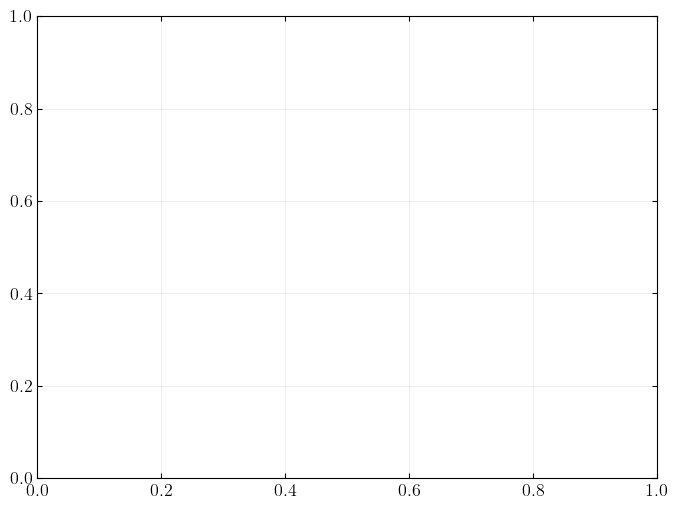

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

SZ = np.array([[1, 0], [0, -1]])

import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Compute normalization parameters for the energy values of all solutions

# Create a single axis for the plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(times, baseline, "k--", label="QuTiP (baseline)")

velox_results.sort_values(by=['gap'], inplace=True)
energy_vals = velox_results['gap'].values
norm = mcolors.Normalize(vmin=0, vmax=1)
cmap = cm.viridis


# Loop over all rows in velox_results and plot all dynamics on the same panel,
# coloring each curve according to its best_energy.
colors = ["r", "g", "b", "c", "m", "y", "k"]
markers = ["o", "s", "^", "D", "v", "<", ">"]

cnt = 0
existing_energies = []
for idx, row in velox_results.iterrows():
  sol = row['best_solution']
  sol_list = [0 if x.strip() == "-1" else 1 for x in sol.split(';')]
  sol_dict = {i: sol_list[i] for i in range(len(sol_list))}
  # Compute the dynamics using the problem's interpretation method.
  vec = problem.interpret_sample(sol_dict)
  # For each state in the trajectory, compute ⟨σ_z⟩.
  expect = [(state.conj() @ SZ @ state).real for state in vec]
  energy = row['gap']
  if energy in existing_energies:
    continue
  existing_energies.append(energy)
  cnt += 1
  print(f"Energy: {energy}")
  print("QUBO energy: ", qubo.energy(sol_dict))
  ax.scatter(problem.times, expect, color=colors[cnt % len(colors)], marker=markers[cnt % len(markers)], label=f"Gap: {energy:.2f}%", alpha=1.0, s=100)
  ax.plot(problem.times, expect, color=colors[cnt % len(colors)], alpha=0.5, linewidth=0.1)
  print(expect)
  if cnt == 5:
    break

ax.set_xlabel("Time t", fontsize=16)
ax.set_ylabel(r"$\langle \sigma_z \rangle$", fontsize=16)


plt.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.savefig(f"../velox/results/dynamics_plots/precision_{problem.num_bits_per_var}_timepoints_{len(problem.times)}.pdf", dpi=300)
plt.show()


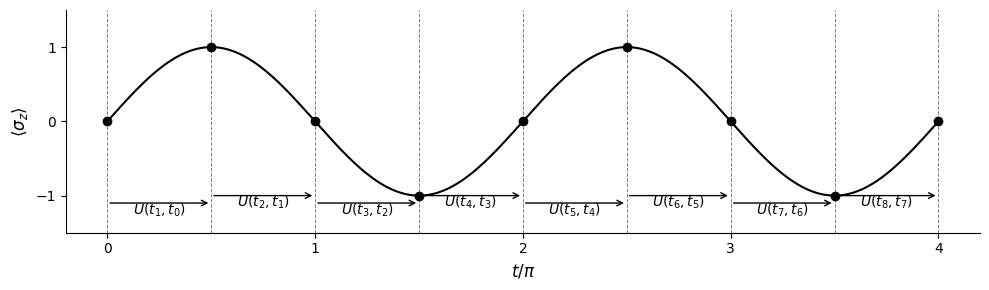

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Czas i funkcja falowa (sinus)
t = np.linspace(0, 4*np.pi, 1000)
psi = np.sin(t)

# Punkty stroboskopowe
t_strobe = np.linspace(0, 4*np.pi, 9)
psi_strobe = np.sin(t_strobe)

# Przygotowanie wykresu
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(t / np.pi, psi, color='black', linewidth=1.5, label=r'$\psi(t)$')  # przeskalowany czas

# pionowe linie stroboskopowe
for t_i in t_strobe:
    ax.axvline(t_i / np.pi, color='gray', linestyle='--', linewidth=0.7)

# Strzałki między punktami
for i in range(len(t_strobe)-1):
    x_start = t_strobe[i] / np.pi
    x_end = t_strobe[i+1] / np.pi
    y_pos = -1.1 + 0.1*(i%2)  # naprzemienna wysokość
    ax.annotate('', xy=(x_end, y_pos), xytext=(x_start, y_pos),
                arrowprops=dict(arrowstyle='->', color='black', linewidth=1))

    # Podpis U(t_{i+1}, t_i)
    ax.text((x_start + x_end)/2, y_pos - 0.15,
            r'$U(t_{%d}, t_{%d})$' % (i+1, i), ha='center', fontsize=10)

# Punkty dyskretne na funkcji
ax.plot(t_strobe / np.pi, psi_strobe, 'o', color='black')

# Opisy osi
ax.set_xlabel(r'$t/\pi$', fontsize=12)
ax.set_ylabel(r'$\langle \sigma_z \rangle$', fontsize=12)

# Styl techniczny
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(0, 4.5, 1))
ax.set_yticks([-1, 0, 1])
ax.set_ylim(-1.5, 1.5)

plt.tight_layout()
plt.show()


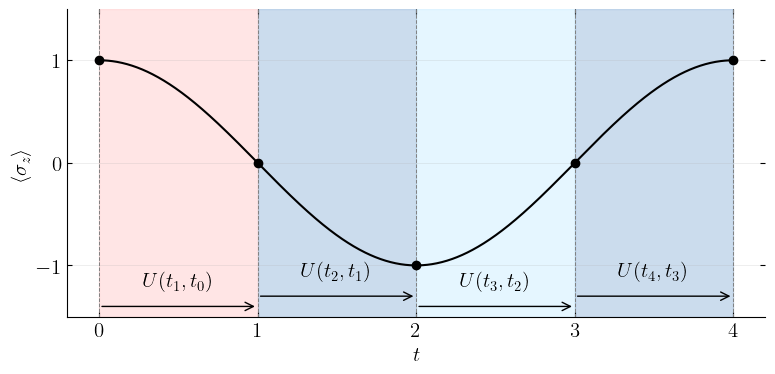

In [37]:
import matplotlib.pyplot as plt
import numpy as np
helpers.set_pub_style(fontsize=15)
# Czas i fala
t = np.linspace(0, 4, 1000)
psi = np.cos(np.pi * t / 2)  # fala zaczyna w 1, potem 0, -1, 0, 1

# Hamiltonian: zmienia się co 1 jednostkę czasu
hamiltonian_values = [1, 0, -1, 0]
color_map = {1: '#ffcccc', 0: '#99bbdd', -1: '#cceeff'}
t_strobe = np.arange(0, 5)

# Wykres
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(t, psi, color='black', linewidth=1.5, label=r'$\psi(t)$')

# Kolorowe tła i ewolucje jednostkowe
for i in range(len(t_strobe) - 1):
    x_start = t_strobe[i]
    x_end = t_strobe[i+1]
    h_val = hamiltonian_values[i]
    ax.axvspan(x_start, x_end, color=color_map[h_val], alpha=0.5)
    ax.axvline(x_start, color='gray', linestyle='--', linewidth=0.7)

    y_pos = -1.4 + 0.1 * (i % 2)
    ax.annotate('', xy=(x_end, y_pos), xytext=(x_start, y_pos),
                arrowprops=dict(arrowstyle='->', color='black', linewidth=1))
    ax.text((x_start + x_end)/2, y_pos +0.2,
            r'$U(t_{%d}, t_{%d})$' % (i+1, i), ha='center')

# Ostatnia linia
ax.axvline(t_strobe[-1], color='gray', linestyle='--', linewidth=0.7)

# Punkty stroboskopowe
psi_strobe = np.cos(np.pi * t_strobe / 2)
ax.plot(t_strobe, psi_strobe, 'o', color='black')

# Opisy osi
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\langle \sigma_z \rangle$')
ax.set_xticks(np.arange(0, 5, 1))
ax.set_yticks([-1, 0, 1])
ax.set_ylim(-1.5, 1.5)

# Styl
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('../plots/introductory_time_evol.pdf',bbox_inches='tight')

plt.show()


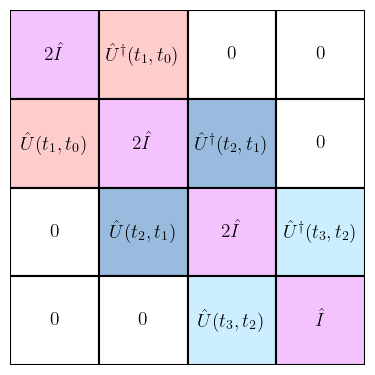

In [36]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
helpers.set_pub_style(fontsize=15)

# Matrix entries using LaTeX for math formatting
matrix = [
    [r"$2\hat{I}$", r"$\hat{U}^\dagger(t_1,t_0)$", r"$0$", r"$0$"],
    [r"$\hat{U}(t_1,t_0)$", r"$2\hat{I}$",r"$\hat{U}^\dagger(t_2,t_1)$" , r"$0$"],
    [r"$0$", r"$\hat{U}(t_2,t_1)$", r"$2\hat{I}$", r"$\hat{U}^\dagger(t_3,t_2)$"],
    [r"$0$", r"$0$", r"$\hat{U}(t_3,t_2)$", r"$\hat{I}$"]
]

colors = [
    ["#f4c2ff", "#ffcccc", "#ffffff", "#ffffff"],
    ["#ffcccc", "#f4c2ff", "#99bbdd", "#ffffff"],
    ["#ffffff", "#99bbdd", "#f4c2ff", "#cceeff"],
    ["#ffffff", "#ffffff", "#cceeff", "#f4c2ff"]
]

fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)
ax.axis("off")

# Draw cells with colors and LaTeX text
for i in range(4):
    for j in range(4):
        rect = Rectangle((j, 3 - i), 1, 1, facecolor=colors[i][j],
                         edgecolor='black', linewidth=1.5)
        ax.add_patch(rect)
        ax.text(j + 0.5, 3 - i + 0.5, matrix[i][j],
                ha='center', va='center', fontsize=14)

plt.tight_layout()
plt.savefig('../plots/introductory_matrix.pdf',bbox_inches='tight')

plt.show()


/tmp/ipykernel_10101/3731712219.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


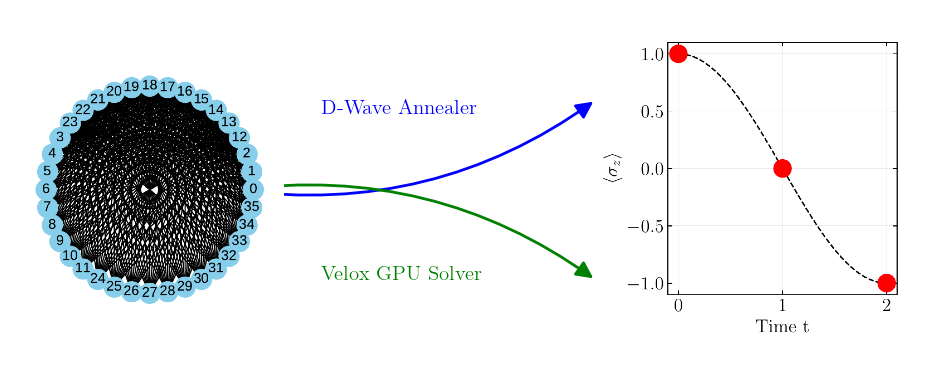

In [93]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pdf2image import convert_from_path

# Convert PDFs to images
input_img = convert_from_path("../plots/input.pdf", dpi=150)[0]
output_img = convert_from_path("../plots/output.pdf", dpi=150)[0]

fig, ax = plt.subplots(figsize=(10, 4))
ax.axis("off")

# Arrows with clip_on=False and padding for visibility
arrow1 = FancyArrowPatch((2.5, 2), (6.7, 3), connectionstyle="arc3,rad=0.2",
                         arrowstyle='-|>', mutation_scale=25, color="blue",
                         linewidth=2, clip_on=False)
arrow2 = FancyArrowPatch((2.5, 2), (6.7, 1), connectionstyle="arc3,rad=-0.2",
                         arrowstyle='-|>', mutation_scale=25, color="green",
                         linewidth=2, clip_on=False)
ax.add_patch(arrow1)
ax.add_patch(arrow2)

# Labels
ax.text(3.5, 2.85, "D-Wave Annealer", fontsize=15, color="blue", weight='bold')
ax.text(3.5, 1.00, "Velox GPU Solver", fontsize=15, color="green", weight='bold')

# Input image
input_box = OffsetImage(input_img, zoom=0.4)
input_ab = AnnotationBbox(input_box, (1.5, 2), frameon=False, pad=0.3)
ax.add_artist(input_ab)

# Output image (same for both)
output_box = OffsetImage(output_img, zoom=0.4)
output_ab = AnnotationBbox(output_box, (8.5, 2), frameon=False, pad=0.3)
ax.add_artist(output_ab)

# Expand the axes a bit more to avoid cutting anything
plt.xlim(0, 10.5)
plt.tight_layout()
plt.ylim(0, 4)
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
plt.savefig('../plots/introductory_transform.pdf',bbox_inches='tight')
plt.show()

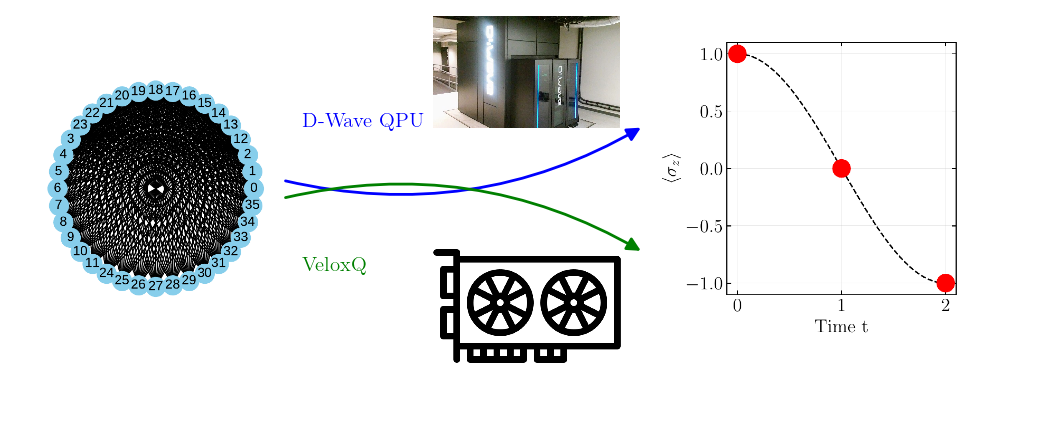

In [115]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pdf2image import convert_from_path
from PIL import Image

# Load and resize PNG images
dwave_img = Image.open("../plots/dwave.jpg")
velox_img = Image.open("../plots/gpu.png")

# Convert PDFs to images
input_img = convert_from_path("../plots/input.pdf", dpi=150)[0]
output_img = convert_from_path("../plots/output.pdf", dpi=150)[0]

fig, ax = plt.subplots(figsize=(11, 4))
ax.axis("off")

# Arrows with clip_on=False and padding for visibility
arrow1 = FancyArrowPatch((2.8, 2.1), (6.5, 2.7), connectionstyle="arc3,rad=0.2",
                         arrowstyle='-|>', mutation_scale=20, color="blue",
                         linewidth=2, clip_on=False)
arrow2 = FancyArrowPatch((2.8, 1.9), (6.5, 1.3), connectionstyle="arc3,rad=-0.2",
                         arrowstyle='-|>', mutation_scale=20, color="green",
                         linewidth=2, clip_on=False)
ax.add_patch(arrow1)
ax.add_patch(arrow2)

# Labels
ax.text(3, 2.7, "D-Wave QPU", fontsize=15, color="blue", weight='bold')
ax.text(3, 1.1, "VeloxQ", fontsize=15, color="green", weight='bold')

# Input image
input_box = OffsetImage(input_img, zoom=0.38)
input_ab = AnnotationBbox(input_box, (1.5, 2), frameon=False, pad=0.3)
ax.add_artist(input_ab)

# Output image
output_box = OffsetImage(output_img, zoom=0.4)
output_ab = AnnotationBbox(output_box, (8.2, 2), frameon=False, pad=0.3)
ax.add_artist(output_ab)

# D-Wave image (small, under arrow)
dwave_box = OffsetImage(dwave_img, zoom=0.14)
dwave_ab = AnnotationBbox(dwave_box, (5.3, 3.3), frameon=False, pad=0.1)
ax.add_artist(dwave_ab)

# Velox GPU image (small, under arrow)
velox_box = OffsetImage(velox_img, zoom=0.3)
velox_ab = AnnotationBbox(velox_box, (5.3, 0.7), frameon=False, pad=0.1)
ax.add_artist(velox_ab)

# Set limits to ensure clean framing
ax.set_xlim(0, 10.5)
ax.set_ylim(0, 4)
plt.subplots_adjust(left=0.02, right=0.95, top=0.95, bottom=0.05)

plt.savefig('../plots/introductory_transform.pdf', bbox_inches='tight')
plt.show()


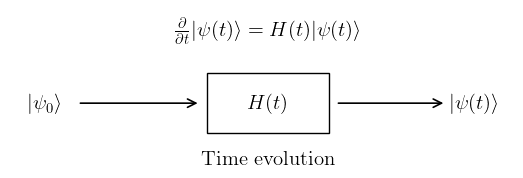

In [81]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Create figure and axis
fig, ax = plt.subplots(figsize=(6.5, 2))
ax.axis("off")

# Coordinates
x0, y0 = 0.5, 0.5  # psi_0
x1, y1 = 2.3, 0.5  # H(t) box
x2, y2 = 4.0, 0.5  # psi(t)

# Draw psi_0
ax.text(x0, y0, r"$|\psi_0\rangle$", fontsize=15, va='center', ha='center')

# Draw H(t) box
box_width = 1.0
box_height = 0.7
H_box = Rectangle((x1 - box_width/2, y1 - box_height/2), box_width, box_height,
                  edgecolor='black', facecolor='white')
ax.add_patch(H_box)
ax.text(x1, y1, r"$H(t)$", fontsize=15, va='center', ha='center')

# Draw psi(t)
ax.text(x2, y2, r"$|\psi(t)\rangle$", fontsize=15, va='center', ha='center')

# Arrows (shorter)
ax.annotate("", xy=(x1 - box_width/2 - 0.05, y1), xytext=(x0 + 0.25, y0),
            arrowprops=dict(arrowstyle="->", lw=1.2))
ax.annotate("", xy=(x2 - 0.25, y2), xytext=(x1 + box_width/2 + 0.05, y1),
            arrowprops=dict(arrowstyle="->", lw=1.2))

# Schrödinger equation above
ax.text(x1, y1 + 0.85, r"$\frac{\partial}{\partial t}|\psi(t)\rangle = H(t)|\psi(t)\rangle$",
        fontsize=15, va='center', ha='center')

# Time evolution label
ax.text(x1, y1 - 0.65, "Time evolution", fontsize=15, va='center', ha='center')

# Adjust limits tightly to content
ax.set_xlim(0.2, 4.3)
ax.set_ylim(-0.2, 1.6)
# Save to PDF with minimal whitespace
plt.savefig('../plots/introductory_formula.pdf',bbox_inches='tight')
plt.show()
